In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
import numpy as np

In [5]:
import sys
import os
from os.path import dirname
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sys.path.append(dirname('../src'))
from src.utils import utils
data = utils.load_df("../Data/feature_eng.pkl")
data.head(5)

,ventana,sexo,sum_num_consultas,avg_num_consultas_by_year,dm,renal,preglucosa,num_med_preglucosa,avg_preglucosa,min_preglucosa,...,comp_aten_med_qx_no_clasif,num_med_comp_aten_med_qx_no_clasif,avg_comp_aten_med_qx_no_clasif,sec_traumatismos_envenenamiento_causas_ext,num_med_sec_traumatismos_envenenamiento_causas_ext,avg_sec_traumatismos_envenenamiento_causas_ext,ot_efec_causas_ext_comp_traumatismos,num_med_ot_efec_causas_ext_comp_traumatismos,avg_ot_efec_causas_ext_comp_traumatismos,label
0,1,M,25,12.5,0,0,1,9,150,108,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
1,2,M,24,12,0,0,1,4,158,109,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
2,3,M,21,10.5,0,0,1,1,253,253,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0
3,4,M,20,10,0,0,1,4,155.75,80,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,1
4,1,M,4,2,0,0,0,NaN,NaN,NaN,...,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0


- Eliminando columnas que no aportan información

In [6]:
subset_df = data.loc[:, data.isnull().all()]
col_null = list(subset_df.columns)
col_null

['num_med_ldl',
 'avg_ldl',
 'min_ldl',
 'max_ldl',
 'num_med_plaquetas',
 'avg_plaquetas',
 'min_plaquetas',
 'max_plaquetas',
 'num_med_tuberculosis',
 'avg_tuberculosis',
 'num_med_ot_enf_bacterianas',
 'avg_ot_enf_bacterianas',
 'num_med_inf_trans_pred_sexual',
 'avg_inf_trans_pred_sexual',
 'num_med_rickettsiosis_y_ot_enf__protozoarios',
 'avg_rickettsiosis_y_ot_enf__protozoarios',
 'num_med_tumores_malig_labio_bucal_faringe',
 'avg_tumores_malig_labio_bucal_faringe',
 'num_med_tumores_malig_organos',
 'avg_tumores_malig_organos',
 'num_med_tumores_malig_org_genitourinarios',
 'avg_tumores_malig_org_genitourinarios',
 'num_med_tumores_malig_otros_sitios_ne',
 'avg_tumores_malig_otros_sitios_ne',
 'num_med_tumores_malig_tejido_linf_org_hematop',
 'avg_tumores_malig_tejido_linf_org_hematop',
 'num_med_tumores_comp_incierto_desc',
 'avg_tumores_comp_incierto_desc',
 'num_med_enf_sangre_org_hematop',
 'avg_enf_sangre_org_hematop',
 'num_med_desnutricion_ot_deficiencias',
 'avg_desnutr

In [7]:
data.drop(col_null, axis=1, inplace=True)
list(data.columns)

['ventana',
 'sexo',
 'sum_num_consultas',
 'avg_num_consultas_by_year',
 'dm',
 'renal',
 'preglucosa',
 'num_med_preglucosa',
 'avg_preglucosa',
 'min_preglucosa',
 'max_preglucosa',
 'postglucosa',
 'num_med_postglucosa',
 'avg_postglucosa',
 'min_postglucosa',
 'max_postglucosa',
 'colesterol',
 'num_med_colesterol',
 'avg_colesterol',
 'min_colesterol',
 'max_colesterol',
 'trigliceridos',
 'num_med_trigliceridos',
 'avg_trigliceridos',
 'min_trigliceridos',
 'max_trigliceridos',
 'hdl',
 'num_med_hdl',
 'avg_hdl',
 'min_hdl',
 'max_hdl',
 'ldl',
 'presion_arterial',
 'num_med_presion_a',
 'avg_sistolica_a',
 'min_sistolica_a',
 'max_sistolica_a',
 'avg_diastolica_a',
 'min_diastolica_a',
 'max_diastolica_a',
 'hba1c',
 'num_med_hba1c',
 'avg_hba1c',
 'min_hba1c',
 'max_hba1c',
 'plaquetas',
 'creatinina',
 'num_med_creatinina',
 'avg_creatinina',
 'min_creatinina',
 'max_creatinina',
 'acido_urico',
 'num_med_acido_urico',
 'avg_acido_urico',
 'min_acido_urico',
 'max_acido_urico

In [8]:
data.shape

(154, 218)

In [9]:
data['imc_range'] = data['imc_range'].fillna('Sin dato')
data['sexo'] = data['sexo'].fillna('Sin dato')

In [10]:
df_st = data[['sexo','imc_range']]
display(df_st.head(5))
df1 = data.drop(['sexo','imc_range'], axis=1)
display(df1.head(5))

,sexo,imc_range
0,M,Obesidad Grado 1
1,M,Obesidad Grado 1
2,M,Obesidad Grado 1
3,M,Obesidad Grado 1
4,M,Obesidad Grado 2


,ventana,sum_num_consultas,avg_num_consultas_by_year,dm,renal,preglucosa,num_med_preglucosa,avg_preglucosa,min_preglucosa,max_preglucosa,...,avg_sindrome_maltrato,comp_precoces_traumatismos,num_med_comp_precoces_traumatismos,avg_comp_precoces_traumatismos,comp_aten_med_qx_no_clasif,num_med_comp_aten_med_qx_no_clasif,avg_comp_aten_med_qx_no_clasif,sec_traumatismos_envenenamiento_causas_ext,ot_efec_causas_ext_comp_traumatismos,label
0,1,25,12.5,0,0,1,9,150,108,373,...,12.5,1,25,12.5,0,NaN,NaN,0,0,0
1,2,24,12,0,0,1,4,158,109,253,...,12,1,24,12,0,NaN,NaN,0,0,0
2,3,21,10.5,0,0,1,1,253,253,253,...,10.5,1,21,10.5,0,NaN,NaN,0,0,0
3,4,20,10,0,0,1,4,155.75,80,210,...,10,1,20,10,0,NaN,NaN,0,0,1
4,1,4,2,0,0,0,NaN,NaN,NaN,NaN,...,2,1,4,2,0,NaN,NaN,0,0,0


### Imputaciones

In [11]:
list(df1.columns)

['ventana',
 'sum_num_consultas',
 'avg_num_consultas_by_year',
 'dm',
 'renal',
 'preglucosa',
 'num_med_preglucosa',
 'avg_preglucosa',
 'min_preglucosa',
 'max_preglucosa',
 'postglucosa',
 'num_med_postglucosa',
 'avg_postglucosa',
 'min_postglucosa',
 'max_postglucosa',
 'colesterol',
 'num_med_colesterol',
 'avg_colesterol',
 'min_colesterol',
 'max_colesterol',
 'trigliceridos',
 'num_med_trigliceridos',
 'avg_trigliceridos',
 'min_trigliceridos',
 'max_trigliceridos',
 'hdl',
 'num_med_hdl',
 'avg_hdl',
 'min_hdl',
 'max_hdl',
 'ldl',
 'presion_arterial',
 'num_med_presion_a',
 'avg_sistolica_a',
 'min_sistolica_a',
 'max_sistolica_a',
 'avg_diastolica_a',
 'min_diastolica_a',
 'max_diastolica_a',
 'hba1c',
 'num_med_hba1c',
 'avg_hba1c',
 'min_hba1c',
 'max_hba1c',
 'plaquetas',
 'creatinina',
 'num_med_creatinina',
 'avg_creatinina',
 'min_creatinina',
 'max_creatinina',
 'acido_urico',
 'num_med_acido_urico',
 'avg_acido_urico',
 'min_acido_urico',
 'max_acido_urico',
 'urea

In [12]:
# Imputation
my_imputer = SimpleImputer()
d_inp = pd.DataFrame(my_imputer.fit_transform(df1))
d_inp

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,1.0,25.0,12.5,0.0,0.0,1.0,9.000000,150.000000,108.000000,373.000000,...,12.5,1.0,25.0,12.5,0.0,1.0,0.5,0.0,0.0,0.0
1,2.0,24.0,12.0,0.0,0.0,1.0,4.000000,158.000000,109.000000,253.000000,...,12.0,1.0,24.0,12.0,0.0,1.0,0.5,0.0,0.0,0.0
2,3.0,21.0,10.5,0.0,0.0,1.0,1.000000,253.000000,253.000000,253.000000,...,10.5,1.0,21.0,10.5,0.0,1.0,0.5,0.0,0.0,0.0
3,4.0,20.0,10.0,0.0,0.0,1.0,4.000000,155.750000,80.000000,210.000000,...,10.0,1.0,20.0,10.0,0.0,1.0,0.5,0.0,0.0,1.0
4,1.0,4.0,2.0,0.0,0.0,0.0,3.941176,157.012007,125.188235,199.752941,...,2.0,1.0,4.0,2.0,0.0,1.0,0.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2.0,15.0,7.5,1.0,0.0,1.0,3.000000,146.666667,140.000000,160.000000,...,1.0,1.0,2.0,1.0,0.0,1.0,0.5,0.0,0.0,1.0
150,1.0,10.0,5.0,0.0,0.0,1.0,2.000000,118.500000,113.000000,124.000000,...,5.0,1.0,10.0,5.0,0.0,1.0,0.5,0.0,0.0,0.0
151,2.0,5.0,2.5,0.0,0.0,0.0,3.941176,157.012007,125.188235,199.752941,...,2.5,1.0,5.0,2.5,0.0,1.0,0.5,0.0,0.0,0.0
152,3.0,6.0,3.0,0.0,0.0,1.0,1.000000,118.000000,118.000000,118.000000,...,3.0,1.0,6.0,3.0,0.0,1.0,0.5,0.0,0.0,0.0


In [13]:
d_inp.shape

(154, 216)

In [14]:
d_inp.columns = ['ventana',
 'sum_num_consultas',
 'avg_num_consultas_by_year',
 'dm',
 'renal',
 'preglucosa',
 'num_med_preglucosa',
 'avg_preglucosa',
 'min_preglucosa',
 'max_preglucosa',
 'postglucosa',
 'num_med_postglucosa',
 'avg_postglucosa',
 'min_postglucosa',
 'max_postglucosa',
 'colesterol',
 'num_med_colesterol',
 'avg_colesterol',
 'min_colesterol',
 'max_colesterol',
 'trigliceridos',
 'num_med_trigliceridos',
 'avg_trigliceridos',
 'min_trigliceridos',
 'max_trigliceridos',
 'hdl',
 'num_med_hdl',
 'avg_hdl',
 'min_hdl',
 'max_hdl',
 'ldl',
 'presion_arterial',
 'num_med_presion_a',
 'avg_sistolica_a',
 'min_sistolica_a',
 'max_sistolica_a',
 'avg_diastolica_a',
 'min_diastolica_a',
 'max_diastolica_a',
 'hba1c',
 'num_med_hba1c',
 'avg_hba1c',
 'min_hba1c',
 'max_hba1c',
 'plaquetas',
 'creatinina',
 'num_med_creatinina',
 'avg_creatinina',
 'min_creatinina',
 'max_creatinina',
 'acido_urico',
 'num_med_acido_urico',
 'avg_acido_urico',
 'min_acido_urico',
 'max_acido_urico',
 'urea',
 'num_med_urea',
 'avg_urea',
 'min_urea',
 'max_urea',
 'peso',
 'num_med_peso',
 'avg_peso',
 'min_peso',
 'max_peso',
 'altura',
 'num_med_altura',
 'avg_altura',
 'min_altura',
 'max_altura',
 'tfg',
 'num_med_tfg',
 'avg_tfg',
 'min_tfg',
 'max_tfg',
 'edad',
 'num_med_edad',
 'avg_edad',
 'min_edad',
 'max_edad',
 'dif_date_lab',
 'num_med_dif_date_lab',
 'avg_dif_date_lab',
 'min_dif_date_lab',
 'max_dif_date_lab',
 'imc',
 'num_med_imc_calculado',
 'avg_dif_imc_calculado',
 'min_dif_imc_calculado',
 'max_dif_imc_calculado',
 'vent_entre_consul',
 'num_med_vent_entre_consul',
 'avg_vent_entre_consul',
 'min_dif_vent_entre_consul',
 'max_dif_vent_entre_consul',
 'vent_entre_lab',
 'num_med_vent_entre_lab',
 'avg_vent_entre_lab',
 'min_dif_vent_entre_lab',
 'max_dif_vent_entre_lab',
 'enf_inf_intestinales',
 'num_med_enf_inf_intestinales',
 'avg_enf_inf_intestinales',
 'tuberculosis',
 'ot_enf_bacterianas',
 'inf_trans_pred_sexual',
 'ot_enf_inf_y_paras_y_efec_tardios',
 'num_med_ot_enf_inf_y_paras_y_efec_tardios',
 'avg_ot_enf_inf_y_paras_y_efec_tardios',
 'enf_viricas',
 'num_med_enf_viricas',
 'avg_enf_viricas',
 'rickettsiosis_y_ot_enf__protozoarios',
 'tumores_malig_labio_bucal_faringe',
 'tumores_malig_organos',
 'tumores_malig_org_respiratorios_intratoracicos',
 'num_med_tumores_malig_org_respiratorios_intratoracicos',
 'avg_tumores_malig_org_respiratorios_intratoracicos',
 'tumores_malig_huesos_articulares_conjuntivo_piel_mama',
 'num_med_tumores_malig_huesos_articulares_conjuntivo_piel_mama',
 'avg_tumores_malig_huesos_articulares_conjuntivo_piel_mama',
 'tumores_malig_org_genitourinarios',
 'tumores_malig_otros_sitios_ne',
 'tumores_malig_tejido_linf_org_hematop',
 'tumores_malig_sitios_mul_indep',
 'num_med_tumores_malig_sitios_mul_indep',
 'avg_tumores_malig_sitios_mul_indep',
 'tumores_insitu',
 'num_med_tumores_insitu',
 'avg_tumores_insitu',
 'tumores_benignos',
 'num_med_tumores_benignos',
 'avg_tumores_benignos',
 'tumores_comp_incierto_desc',
 'enf_sangre_org_hematop',
 'enf_endocrinas',
 'num_med_enf_endocrinas',
 'avg_enf_endocrinas',
 'desnutricion_ot_deficiencias',
 'trastornos_mentales',
 'num_med_trastornos_mentales',
 'avg_trastornos_mentales',
 'enf_sist_nervioso',
 'num_med_enf_sist_nervioso',
 'avg_enf_sist_nervioso',
 'enf_ojo_anexos',
 'enf_oido_apofisis_mastoides',
 'fiebre_y_enf_cardiacas_reumaticas',
 'num_med_fiebre_y_enf_cardiacas_reumaticas',
 'avg_fiebre_y_enf_cardiacas_reumaticas',
 'enf_hipertensivas',
 'enf_isquemicas_corazon',
 'enf_circulacion_pulmonar_enf_corazon',
 'num_med_enf_circulacion_pulmonar_enf_corazon',
 'avg_enf_circulacion_pulmonar_enf_corazon',
 'enf_cerebrovasculares',
 'num_med_enf_cerebrovasculares',
 'avg_enf_cerebrovasculares',
 'otras_enf_aparato_vasc',
 'num_med_otras_enf_aparato_vasc',
 'avg_otras_enf_aparato_vasc',
 'inf_y_enf_vias_respiratorias_sup',
 'num_med_inf_y_enf_vias_respiratorias_sup',
 'avg_inf_y_enf_vias_respiratorias_sup',
 'otras_enf_aparato_resp',
 'enf_cavidad_bucal_glandulas_salivales',
 'enf_ot_partes_aparato_digestivo',
 'num_med_enf_ot_partes_aparato_digestivo',
 'avg_enf_ot_partes_aparato_digestivo',
 'enf_piel_tejido_subcutaneo',
 'enf_sist_osteomuscular_y_tejido',
 'num_med_enf_sist_osteomuscular_y_tejido',
 'avg_enf_sist_osteomuscular_y_tejido',
 'enf_aparato_urinario',
 'num_med_enf_aparato_urinario',
 'avg_enf_aparato_urinario',
 'enf_org_genitales_masculinos',
 'num_med_enf_org_genitales_masculinos',
 'avg_enf_org_genitales_masculinos',
 'trastornos_mama',
 'num_med_trastornos_mama',
 'avg_trastornos_mama',
 'enf_org_genitales_femeninos',
 'num_med_enf_org_genitales_femeninos',
 'avg_enf_org_genitales_femeninos',
 'trastornos_sist_genitourinario_consec_proced',
 'num_med_trastornos_sist_genitourinario_consec_proced',
 'avg_trastornos_sist_genitourinario_consec_proced',
 'causas_obstetricas_directas',
 'parto',
 'causas_obstetricas_indirectas',
 'malformaciones_congenitas',
 'num_med_malformaciones_congenitas',
 'avg_malformaciones_congenitas',
 'sintomas_signos_hallazgos_anormales_clin_lab_no_clasif',
 'num_med_sintomas_signos_hallazgos_anormales_clin_lab_no_clasif',
 'avg_sintomas_signos_hallazgos_anormales_clin_lab_no_clasif',
 'fracturas',
 'luxaciones_esguinces_torceduras',
 'traumatismos_int_intracraneales_y_otr',
 'heridas',
 'efec_cuerpos_extr_pen_orificios_naturales',
 'quemaduras_corrosiones',
 'envenenamiento_efectos_tox',
 'sindrome_maltrato',
 'num_med_sindrome_maltrato',
 'avg_sindrome_maltrato',
 'comp_precoces_traumatismos',
 'num_med_comp_precoces_traumatismos',
 'avg_comp_precoces_traumatismos',
 'comp_aten_med_qx_no_clasif',
 'num_med_comp_aten_med_qx_no_clasif',
 'avg_comp_aten_med_qx_no_clasif',
 'sec_traumatismos_envenenamiento_causas_ext',
 'ot_efec_causas_ext_comp_traumatismos',
 'label']
d_inp

,ventana,sum_num_consultas,avg_num_consultas_by_year,dm,renal,preglucosa,num_med_preglucosa,avg_preglucosa,min_preglucosa,max_preglucosa,...,avg_sindrome_maltrato,comp_precoces_traumatismos,num_med_comp_precoces_traumatismos,avg_comp_precoces_traumatismos,comp_aten_med_qx_no_clasif,num_med_comp_aten_med_qx_no_clasif,avg_comp_aten_med_qx_no_clasif,sec_traumatismos_envenenamiento_causas_ext,ot_efec_causas_ext_comp_traumatismos,label
0,1.0,25.0,12.5,0.0,0.0,1.0,9.000000,150.000000,108.000000,373.000000,...,12.5,1.0,25.0,12.5,0.0,1.0,0.5,0.0,0.0,0.0
1,2.0,24.0,12.0,0.0,0.0,1.0,4.000000,158.000000,109.000000,253.000000,...,12.0,1.0,24.0,12.0,0.0,1.0,0.5,0.0,0.0,0.0
2,3.0,21.0,10.5,0.0,0.0,1.0,1.000000,253.000000,253.000000,253.000000,...,10.5,1.0,21.0,10.5,0.0,1.0,0.5,0.0,0.0,0.0
3,4.0,20.0,10.0,0.0,0.0,1.0,4.000000,155.750000,80.000000,210.000000,...,10.0,1.0,20.0,10.0,0.0,1.0,0.5,0.0,0.0,1.0
4,1.0,4.0,2.0,0.0,0.0,0.0,3.941176,157.012007,125.188235,199.752941,...,2.0,1.0,4.0,2.0,0.0,1.0,0.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2.0,15.0,7.5,1.0,0.0,1.0,3.000000,146.666667,140.000000,160.000000,...,1.0,1.0,2.0,1.0,0.0,1.0,0.5,0.0,0.0,1.0
150,1.0,10.0,5.0,0.0,0.0,1.0,2.000000,118.500000,113.000000,124.000000,...,5.0,1.0,10.0,5.0,0.0,1.0,0.5,0.0,0.0,0.0
151,2.0,5.0,2.5,0.0,0.0,0.0,3.941176,157.012007,125.188235,199.752941,...,2.5,1.0,5.0,2.5,0.0,1.0,0.5,0.0,0.0,0.0
152,3.0,6.0,3.0,0.0,0.0,1.0,1.000000,118.000000,118.000000,118.000000,...,3.0,1.0,6.0,3.0,0.0,1.0,0.5,0.0,0.0,0.0


In [15]:
df_st

,sexo,imc_range
0,M,Obesidad Grado 1
1,M,Obesidad Grado 1
2,M,Obesidad Grado 1
3,M,Obesidad Grado 1
4,M,Obesidad Grado 2
...,...,...
149,F,Sobrepeso
150,F,Peso normal
151,F,Sobrepeso
152,F,Sobrepeso


In [16]:
df = pd.merge(d_inp, df_st, left_index=True, right_index=True)  
df

,ventana,sum_num_consultas,avg_num_consultas_by_year,dm,renal,preglucosa,num_med_preglucosa,avg_preglucosa,min_preglucosa,max_preglucosa,...,num_med_comp_precoces_traumatismos,avg_comp_precoces_traumatismos,comp_aten_med_qx_no_clasif,num_med_comp_aten_med_qx_no_clasif,avg_comp_aten_med_qx_no_clasif,sec_traumatismos_envenenamiento_causas_ext,ot_efec_causas_ext_comp_traumatismos,label,sexo,imc_range
0,1.0,25.0,12.5,0.0,0.0,1.0,9.000000,150.000000,108.000000,373.000000,...,25.0,12.5,0.0,1.0,0.5,0.0,0.0,0.0,M,Obesidad Grado 1
1,2.0,24.0,12.0,0.0,0.0,1.0,4.000000,158.000000,109.000000,253.000000,...,24.0,12.0,0.0,1.0,0.5,0.0,0.0,0.0,M,Obesidad Grado 1
2,3.0,21.0,10.5,0.0,0.0,1.0,1.000000,253.000000,253.000000,253.000000,...,21.0,10.5,0.0,1.0,0.5,0.0,0.0,0.0,M,Obesidad Grado 1
3,4.0,20.0,10.0,0.0,0.0,1.0,4.000000,155.750000,80.000000,210.000000,...,20.0,10.0,0.0,1.0,0.5,0.0,0.0,1.0,M,Obesidad Grado 1
4,1.0,4.0,2.0,0.0,0.0,0.0,3.941176,157.012007,125.188235,199.752941,...,4.0,2.0,0.0,1.0,0.5,0.0,0.0,0.0,M,Obesidad Grado 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2.0,15.0,7.5,1.0,0.0,1.0,3.000000,146.666667,140.000000,160.000000,...,2.0,1.0,0.0,1.0,0.5,0.0,0.0,1.0,F,Sobrepeso
150,1.0,10.0,5.0,0.0,0.0,1.0,2.000000,118.500000,113.000000,124.000000,...,10.0,5.0,0.0,1.0,0.5,0.0,0.0,0.0,F,Peso normal
151,2.0,5.0,2.5,0.0,0.0,0.0,3.941176,157.012007,125.188235,199.752941,...,5.0,2.5,0.0,1.0,0.5,0.0,0.0,0.0,F,Sobrepeso
152,3.0,6.0,3.0,0.0,0.0,1.0,1.000000,118.000000,118.000000,118.000000,...,6.0,3.0,0.0,1.0,0.5,0.0,0.0,0.0,F,Sobrepeso


In [17]:
X = df[['ventana',
 'sum_num_consultas',
 'avg_num_consultas_by_year',
 'dm',
 'renal',
 'preglucosa',
 'num_med_preglucosa',
 'avg_preglucosa',
 'min_preglucosa',
 'max_preglucosa',
 'postglucosa',
 'num_med_postglucosa',
 'avg_postglucosa',
 'min_postglucosa',
 'max_postglucosa',
 'colesterol',
 'num_med_colesterol',
 'avg_colesterol',
 'min_colesterol',
 'max_colesterol',
 'trigliceridos',
 'num_med_trigliceridos',
 'avg_trigliceridos',
 'min_trigliceridos',
 'max_trigliceridos',
 'hdl',
 'num_med_hdl',
 'avg_hdl',
 'min_hdl',
 'max_hdl',
 'ldl',
 'presion_arterial',
 'num_med_presion_a',
 'avg_sistolica_a',
 'min_sistolica_a',
 'max_sistolica_a',
 'avg_diastolica_a',
 'min_diastolica_a',
 'max_diastolica_a',
 'hba1c',
 'num_med_hba1c',
 'avg_hba1c',
 'min_hba1c',
 'max_hba1c',
 'plaquetas',
 'creatinina',
 'num_med_creatinina',
 'avg_creatinina',
 'min_creatinina',
 'max_creatinina',
 'acido_urico',
 'num_med_acido_urico',
 'avg_acido_urico',
 'min_acido_urico',
 'max_acido_urico',
 'urea',
 'num_med_urea',
 'avg_urea',
 'min_urea',
 'max_urea',
 'peso',
 'num_med_peso',
 'avg_peso',
 'min_peso',
 'max_peso',
 'altura',
 'num_med_altura',
 'avg_altura',
 'min_altura',
 'max_altura',
 'tfg',
 'num_med_tfg',
 'avg_tfg',
 'min_tfg',
 'max_tfg',
 'edad',
 'num_med_edad',
 'avg_edad',
 'min_edad',
 'max_edad',
 'dif_date_lab',
 'num_med_dif_date_lab',
 'avg_dif_date_lab',
 'min_dif_date_lab',
 'max_dif_date_lab',
 'imc',
 'num_med_imc_calculado',
 'avg_dif_imc_calculado',
 'min_dif_imc_calculado',
 'max_dif_imc_calculado',
 'vent_entre_consul',
 'num_med_vent_entre_consul',
 'avg_vent_entre_consul',
 'min_dif_vent_entre_consul',
 'max_dif_vent_entre_consul',
 'vent_entre_lab',
 'num_med_vent_entre_lab',
 'avg_vent_entre_lab',
 'min_dif_vent_entre_lab',
 'max_dif_vent_entre_lab',
 'enf_inf_intestinales',
 'num_med_enf_inf_intestinales',
 'avg_enf_inf_intestinales',
 'tuberculosis',
 'ot_enf_bacterianas',
 'inf_trans_pred_sexual',
 'ot_enf_inf_y_paras_y_efec_tardios',
 'num_med_ot_enf_inf_y_paras_y_efec_tardios',
 'avg_ot_enf_inf_y_paras_y_efec_tardios',
 'enf_viricas',
 'num_med_enf_viricas',
 'avg_enf_viricas',
 'rickettsiosis_y_ot_enf__protozoarios',
 'tumores_malig_labio_bucal_faringe',
 'tumores_malig_organos',
 'tumores_malig_org_respiratorios_intratoracicos',
 'num_med_tumores_malig_org_respiratorios_intratoracicos',
 'avg_tumores_malig_org_respiratorios_intratoracicos',
 'tumores_malig_huesos_articulares_conjuntivo_piel_mama',
 'num_med_tumores_malig_huesos_articulares_conjuntivo_piel_mama',
 'avg_tumores_malig_huesos_articulares_conjuntivo_piel_mama',
 'tumores_malig_org_genitourinarios',
 'tumores_malig_otros_sitios_ne',
 'tumores_malig_tejido_linf_org_hematop',
 'tumores_malig_sitios_mul_indep',
 'num_med_tumores_malig_sitios_mul_indep',
 'avg_tumores_malig_sitios_mul_indep',
 'tumores_insitu',
 'num_med_tumores_insitu',
 'avg_tumores_insitu',
 'tumores_benignos',
 'num_med_tumores_benignos',
 'avg_tumores_benignos',
 'tumores_comp_incierto_desc',
 'enf_sangre_org_hematop',
 'enf_endocrinas',
 'num_med_enf_endocrinas',
 'avg_enf_endocrinas',
 'desnutricion_ot_deficiencias',
 'trastornos_mentales',
 'num_med_trastornos_mentales',
 'avg_trastornos_mentales',
 'enf_sist_nervioso',
 'num_med_enf_sist_nervioso',
 'avg_enf_sist_nervioso',
 'enf_ojo_anexos',
 'enf_oido_apofisis_mastoides',
 'fiebre_y_enf_cardiacas_reumaticas',
 'num_med_fiebre_y_enf_cardiacas_reumaticas',
 'avg_fiebre_y_enf_cardiacas_reumaticas',
 'enf_hipertensivas',
 'enf_isquemicas_corazon',
 'enf_circulacion_pulmonar_enf_corazon',
 'num_med_enf_circulacion_pulmonar_enf_corazon',
 'avg_enf_circulacion_pulmonar_enf_corazon',
 'enf_cerebrovasculares',
 'num_med_enf_cerebrovasculares',
 'avg_enf_cerebrovasculares',
 'otras_enf_aparato_vasc',
 'num_med_otras_enf_aparato_vasc',
 'avg_otras_enf_aparato_vasc',
 'inf_y_enf_vias_respiratorias_sup',
 'num_med_inf_y_enf_vias_respiratorias_sup',
 'avg_inf_y_enf_vias_respiratorias_sup',
 'otras_enf_aparato_resp',
 'enf_cavidad_bucal_glandulas_salivales',
 'enf_ot_partes_aparato_digestivo',
 'num_med_enf_ot_partes_aparato_digestivo',
 'avg_enf_ot_partes_aparato_digestivo',
 'enf_piel_tejido_subcutaneo',
 'enf_sist_osteomuscular_y_tejido',
 'num_med_enf_sist_osteomuscular_y_tejido',
 'avg_enf_sist_osteomuscular_y_tejido',
 'enf_aparato_urinario',
 'num_med_enf_aparato_urinario',
 'avg_enf_aparato_urinario',
 'enf_org_genitales_masculinos',
 'num_med_enf_org_genitales_masculinos',
 'avg_enf_org_genitales_masculinos',
 'trastornos_mama',
 'num_med_trastornos_mama',
 'avg_trastornos_mama',
 'enf_org_genitales_femeninos',
 'num_med_enf_org_genitales_femeninos',
 'avg_enf_org_genitales_femeninos',
 'trastornos_sist_genitourinario_consec_proced',
 'num_med_trastornos_sist_genitourinario_consec_proced',
 'avg_trastornos_sist_genitourinario_consec_proced',
 'causas_obstetricas_directas',
 'parto',
 'causas_obstetricas_indirectas',
 'malformaciones_congenitas',
 'num_med_malformaciones_congenitas',
 'avg_malformaciones_congenitas',
 'sintomas_signos_hallazgos_anormales_clin_lab_no_clasif',
 'num_med_sintomas_signos_hallazgos_anormales_clin_lab_no_clasif',
 'avg_sintomas_signos_hallazgos_anormales_clin_lab_no_clasif',
 'fracturas',
 'luxaciones_esguinces_torceduras',
 'traumatismos_int_intracraneales_y_otr',
 'heridas',
 'efec_cuerpos_extr_pen_orificios_naturales',
 'quemaduras_corrosiones',
 'envenenamiento_efectos_tox',
 'sindrome_maltrato',
 'num_med_sindrome_maltrato',
 'avg_sindrome_maltrato',
 'comp_precoces_traumatismos',
 'num_med_comp_precoces_traumatismos',
 'avg_comp_precoces_traumatismos',
 'comp_aten_med_qx_no_clasif',
 'num_med_comp_aten_med_qx_no_clasif',
 'avg_comp_aten_med_qx_no_clasif',
 'sec_traumatismos_envenenamiento_causas_ext',
 'ot_efec_causas_ext_comp_traumatismos']]
Y = df[["label"]]

In [18]:
print(X.shape)
print(Y.shape)

(154, 215)
(154, 1)


In [19]:
transformers = [('genero', OneHotEncoder(),['sexo'])]
col_trans_sexo = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)
#este no se corre mas que una sola vez porque es el que calibra
col_trans_sexo.fit(df)
col_trans_sexo.get_feature_names()

['genero__x0_', 'genero__x0_F', 'genero__x0_M']

In [20]:
sexo_transformada = col_trans_sexo.transform(df)
df_sexo = pd.DataFrame(sexo_transformada)
df_sexo.columns = col_trans_sexo.get_feature_names()
df_sexo.head()
df_sexo.replace(np.nan,0)

,genero__x0_,genero__x0_F,genero__x0_M
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
149,0.0,1.0,0.0
150,0.0,1.0,0.0
151,0.0,1.0,0.0
152,0.0,1.0,0.0


In [21]:
transformers = [('imc_r', OneHotEncoder(),['imc_range'])]
col_trans_imc_range = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)
#este no se corre mas que una sola vez porque es el que calibra
col_trans_imc_range.fit(df)
col_trans_imc_range.get_feature_names()

['imc_r__x0_Bajo peso',
 'imc_r__x0_Obesidad Grado 1',
 'imc_r__x0_Obesidad Grado 2',
 'imc_r__x0_Obesidad Grado 3',
 'imc_r__x0_Peso normal',
 'imc_r__x0_Sin dato',
 'imc_r__x0_Sobrepeso']

In [22]:
imc_range_transformada = col_trans_imc_range.transform(df)
df_imc_range = pd.DataFrame(imc_range_transformada.toarray())
df_imc_range.columns = col_trans_imc_range.get_feature_names()
df_imc_range.head()
df_imc_range.replace(np.nan,0)

,imc_r__x0_Bajo peso,imc_r__x0_Obesidad Grado 1,imc_r__x0_Obesidad Grado 2,imc_r__x0_Obesidad Grado 3,imc_r__x0_Peso normal,imc_r__x0_Sin dato,imc_r__x0_Sobrepeso
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
149,0.0,0.0,0.0,0.0,0.0,0.0,1.0
150,0.0,0.0,0.0,0.0,1.0,0.0,0.0
151,0.0,0.0,0.0,0.0,0.0,0.0,1.0
152,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [23]:
print(X.shape)
print(df_imc_range.shape)
print(df_sexo.shape)

(154, 215)
(154, 7)
(154, 3)


- Uniendo onehotencoder

In [24]:
X = pd.concat([X, df_sexo, df_imc_range], axis= 1)

In [25]:
X.shape

(154, 225)

In [26]:
X.dtypes

ventana                       float64
sum_num_consultas             float64
avg_num_consultas_by_year     float64
dm                            float64
renal                         float64
                               ...   
imc_r__x0_Obesidad Grado 2    float64
imc_r__x0_Obesidad Grado 3    float64
imc_r__x0_Peso normal         float64
imc_r__x0_Sin dato            float64
imc_r__x0_Sobrepeso           float64
Length: 225, dtype: object

In [27]:
print(Y.size)
Y = Y.astype(int)

154


In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)

In [29]:
# Parámetros para la mejor selección de variables
grid_param = {
    'n_estimators': [100, 150],
    'min_samples_split': [2, 5, 7, 10,15]
}

#classifier = RandomForestClassifier()
classifier = RandomForestClassifier(oob_score=True, random_state=1234)

#Prepareción del GridSearch
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='precision',
                     cv=2)

In [30]:
#Fit del grid search con r
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=1234),
             param_grid={'min_samples_split': [2, 5, 7, 10, 15],
                         'n_estimators': [100, 150]},
             scoring='precision')

In [31]:
# mejor configuración 
gd_sr.best_estimator_

RandomForestClassifier(oob_score=True, random_state=1234)

In [32]:
gd_sr.best_estimator_.n_features_

225

In [33]:
gd_sr.best_estimator_.oob_score_

0.7570093457943925

### Importancia de variables

In [35]:
best_rf = gd_sr.best_estimator_
best_rf.feature_importances_

array([7.62235424e-02, 1.34793110e-02, 1.08205769e-02, 1.52579390e-02,
       0.00000000e+00, 8.68638547e-04, 1.47592292e-02, 2.66552943e-02,
       5.70493856e-02, 1.97096794e-02, 2.31346684e-03, 0.00000000e+00,
       1.03798726e-03, 1.28803785e-03, 8.50964749e-04, 0.00000000e+00,
       7.77408446e-04, 2.07699423e-03, 2.90354147e-03, 0.00000000e+00,
       0.00000000e+00, 2.11310835e-03, 3.70940720e-03, 0.00000000e+00,
       7.68632957e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.32790479e-02, 1.25526251e-02, 1.42325351e-02, 2.50213277e-02,
       1.92961789e-02, 6.95941473e-03, 1.00487994e-02, 6.05040659e-04,
       1.96263894e-03, 5.14808083e-04, 0.00000000e+00, 7.11178248e-04,
       0.00000000e+00, 2.70779164e-03, 0.00000000e+00, 3.73989112e-03,
       3.47023870e-03, 0.00000000e+00, 5.40485904e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.94036362e-03, 6.38025064e-04,
      

In [36]:
feature_importance = pd.DataFrame({'importance': best_rf.feature_importances_,
                                  'feature': X.columns.values})

In [37]:
importancias = feature_importance.sort_values(by="importance", ascending=False)

In [38]:
pd.set_option('display.max_rows', importancias.shape[0]+1)
importancias

,importance,feature
0,0.076224,ventana
8,0.057049,min_preglucosa
94,0.042874,max_dif_vent_entre_consul
87,0.031687,avg_dif_imc_calculado
69,0.031049,max_altura
7,0.026655,avg_preglucosa
35,0.025021,max_sistolica_a
32,0.023279,num_med_presion_a
92,0.023045,avg_vent_entre_consul
88,0.023037,min_dif_imc_calculado


In [41]:
# Guardando modelo
import pickle
pickle.dump(gd_sr, open("modelo_ing.pkl", "wb"))

### Importancia de variables usando shap

In [3]:
import xgboost
import shap

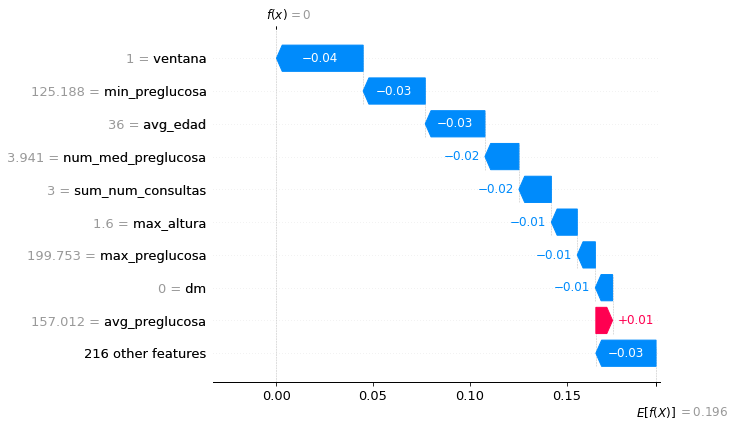

In [34]:
# train an XGBoost model
#X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

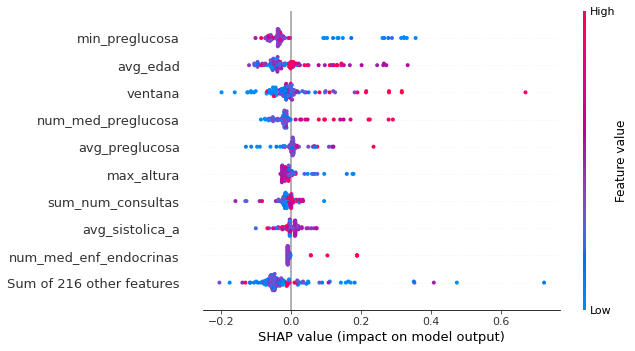

In [37]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

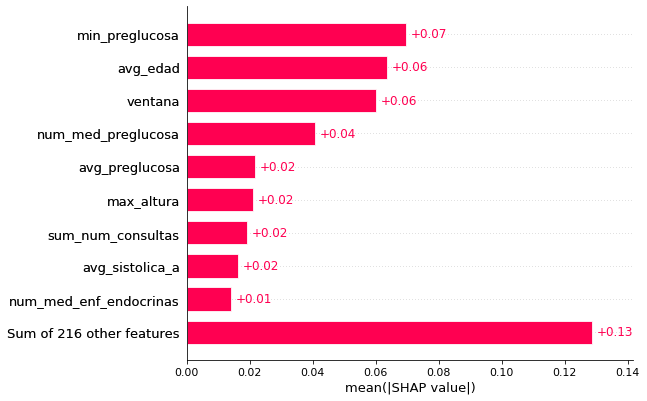

In [38]:
shap.plots.bar(shap_values)